In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

In [2]:
img = cv2.imread("data/dennoban_20181224.png")

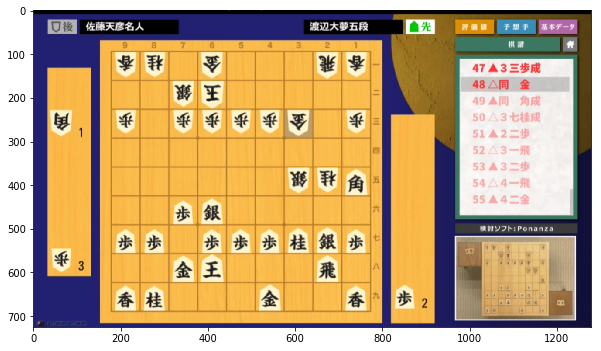

In [3]:
def display_cv2_img(img, figsize=(10,10)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)

display_cv2_img(img)

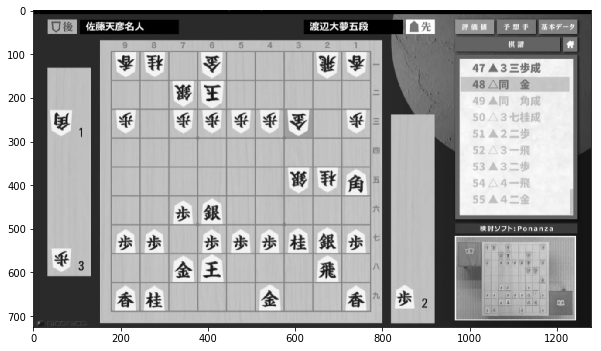

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display_cv2_img(img_gray)

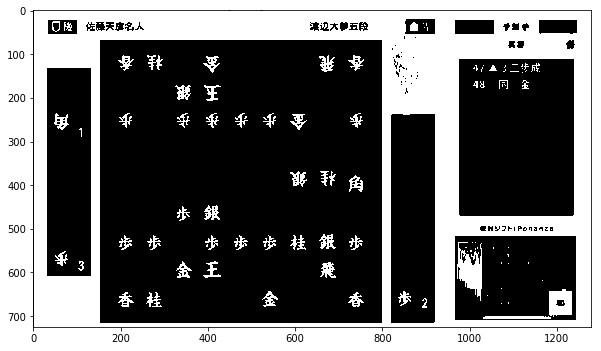

In [5]:
img_blur = img_gray#  cv2.GaussianBlur(img_gray, (11, 11), 0) #(C)
img_threshold = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
display_cv2_img(img_threshold)


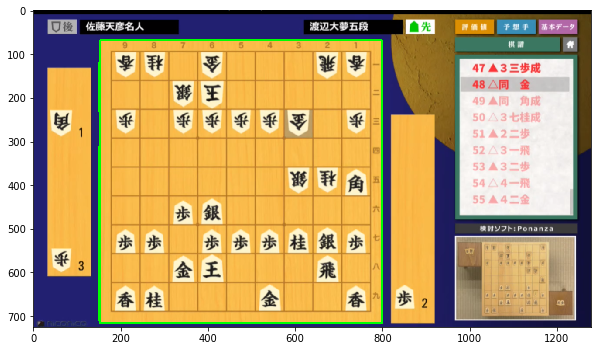

In [6]:
contours = cv2.findContours(img_threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

def area_of_bounding_box(points, verbose=False):
    pts = np.reshape(points, (-1, 2))
    min_pt = np.min(pts, axis=0)
    max_pt = np.max(pts, axis=0)
    delta = max_pt - min_pt
    if verbose:
        print(max_pt, min_pt)
    return delta[0] * delta[1]

sorted_conts = sorted(contours, key=lambda c: area_of_bounding_box(c))

img_cont = img.copy()
img_cont = cv2.drawContours(img_cont, sorted_conts[-2:-1], -1, (0,255,0), 3)
display_cv2_img(img_cont)


(648, 648, 3)
(152, 68, 800, 716)


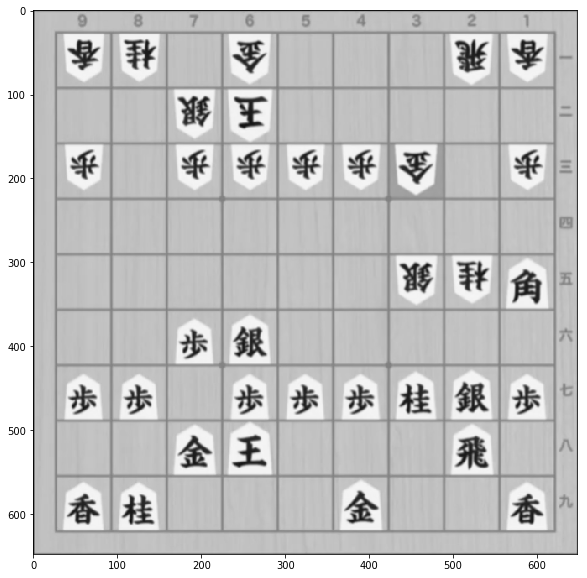

In [13]:
def get_bounding_box(points):
    pts = np.reshape(points, (-1, 2))
    min_pt = np.min(pts, axis=0)
    max_pt = np.max(pts, axis=0)
    return (min_pt[0], min_pt[1], max_pt[0], max_pt[1])
    
main_board = get_bounding_box(sorted_conts[-2])
img_board_gray = img_gray[main_board[1]:main_board[3], main_board[0]:main_board[2]]
img_board = img[main_board[1]:main_board[3], main_board[0]:main_board[2], :]

#img_board_threshold = cv2.threshold(img_board_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

print(img_board.shape)
print(main_board)
display_cv2_img(img_board_gray)

In [24]:
offset_x = 27
offset_y = 27
cell_h = 66
cell_w = 66

def get_cell(img, cell_x, cell_y):
    x1 = offset_x + cell_w * cell_x
    x2 = offset_x + cell_w * (1 + cell_x)
    y1 = offset_y + cell_h * cell_y
    y2 = offset_y + cell_h * (1 + cell_y)
    if len(img.shape) == 3:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

cell_imgs = []
for y in range(9):
    for x in range(9):
        cell_imgs.append(get_cell(img_board, x, y))


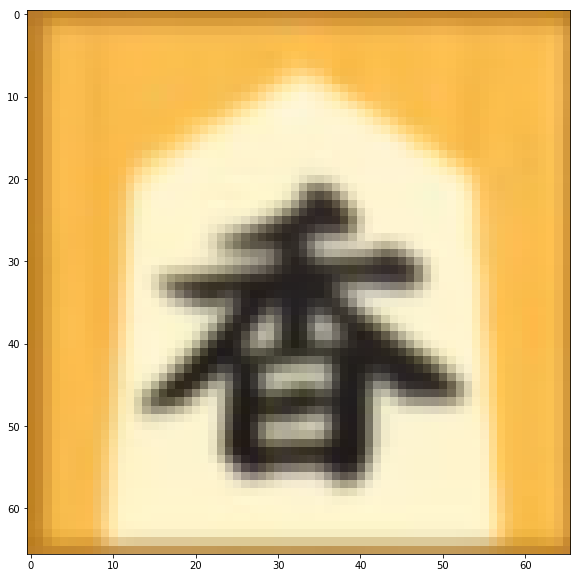

In [26]:
display_cv2_img(cell_imgs[80])